In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_df_to_sort_stock():
    exam_df = pd.read_csv('combined_data_preprocessed_top25_14Jun24.csv')
    mkt_cap_df = exam_df.drop_duplicates(subset=['PERMCO'])[['PERMCO', 'TICKER', 'market_cap']]
    mkt_cap_df = mkt_cap_df.sort_values(by=['market_cap'], ascending=False)
    return mkt_cap_df

In [ ]:
df_to_sort = get_df_to_sort_stock()

In [ ]:
bert_acc = pd.read_csv('./scores/results_bert.csv')
roberta_acc = pd.read_csv('./scores/results_roberta.csv')
dBert_acc = pd.read_csv('./scores/results_distilbert.csv')
dRoberta_acc = pd.read_csv('./scores/results_distilroberta.csv')
finbert_acc = pd.read_csv('./scores/results_finbert.csv')

bert_acc['model'] = 'BERT'
roberta_acc['model'] = 'RoBERTa'
dBert_acc['model'] = 'DistilBERT'
dRoberta_acc['model'] = 'DistilRoBERTa'
finbert_acc['model'] = 'FinBERT'

In [ ]:
def get_report_acc_all():

    all_acc = pd.concat([bert_acc, roberta_acc, dBert_acc, dRoberta_acc, finbert_acc], ignore_index=True)
    tmp = all_acc.groupby(['PERMCO', 'model']).agg({'accuracy': 'mean'}).reset_index()
    tmp = pd.pivot_table(tmp, columns=['model'], values=['accuracy'], index=['PERMCO'])
    tmp = tmp.reset_index().reset_index(drop=True)

    flat_index = [x[1] if x[1] else x[0] for x in tmp.columns]
    tmp.columns = flat_index

    tmp = tmp.merge(df_to_sort, on='PERMCO', how='inner').sort_values(by=['market_cap'], ascending=False)
    tmp = tmp[['TICKER', 'BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']]

    ## Plot average accuracy
    tmp.set_index('TICKER').plot(kind='bar', ylim=(0.4, 0.6), figsize=(12, 4))
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.title('')
    plt.legend(fontsize=7, loc='upper right')
    plt.show()

    ## Plot accuracy over time
    plt.figure(figsize=(12, 4))
    all_acc['predict_year'] = all_acc['start_year'] + 11
    sorter=['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']
    tmp2 = all_acc.sort_values(by=['model'], key=lambda column: column.map(lambda e: sorter.index(e)))
    tmp2 = tmp2.groupby(['predict_year', 'model'])['accuracy'].mean().reset_index()

    plt.plot(tmp2[tmp2['model']=='BERT']['predict_year'], tmp2[tmp2['model']=='BERT']['accuracy'], label='BERT')
    plt.plot(tmp2[tmp2['model']=='RoBERTa']['predict_year'], tmp2[tmp2['model']=='RoBERTa']['accuracy'], label='RoBERTa')
    plt.plot(tmp2[tmp2['model']=='DistilBERT']['predict_year'], tmp2[tmp2['model']=='DistilBERT']['accuracy'], label='DistilBERT')
    plt.plot(tmp2[tmp2['model']=='DistilRoBERTa']['predict_year'], tmp2[tmp2['model']=='DistilRoBERTa']['accuracy'], label='DistilRoBERTa')
    plt.plot(tmp2[tmp2['model']=='FinBERT']['predict_year'], tmp2[tmp2['model']=='FinBERT']['accuracy'], label='FinBERT')

    plt.legend(title="", fontsize=7, loc='upper right')
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Average Accuracy')
    plt.title('')
    plt.show()

    ## Save accuracy table
    bert_avg_acc = tmp['BERT'].mean()
    roberta_avg_acc = tmp['RoBERTa'].mean()
    dBert_avg_acc = tmp['DistilBERT'].mean()
    dRoberta_avg_acc = tmp['DistilRoBERTa'].mean()
    finbert_avg_acc = tmp['FinBERT'].mean()

    tmp.loc[len(tmp.index)] = ['AVG', bert_avg_acc, roberta_avg_acc, dBert_avg_acc, dRoberta_avg_acc, finbert_avg_acc]

    tmp.to_csv('./report_acc_all.csv', index=False)

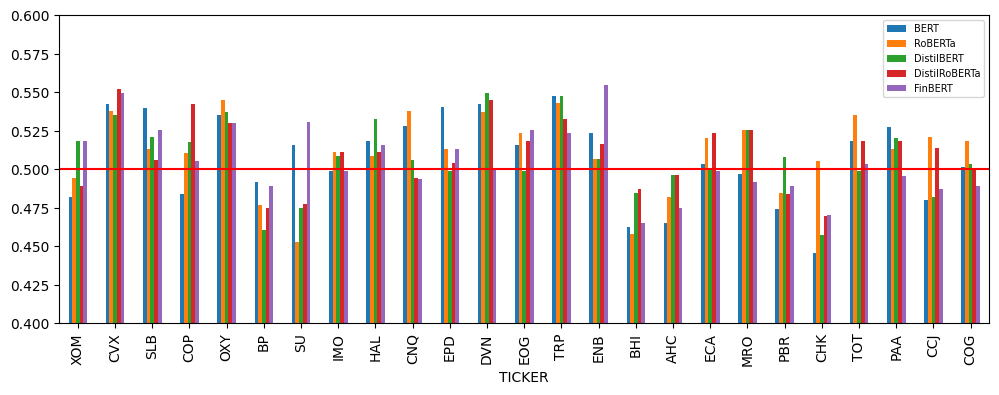

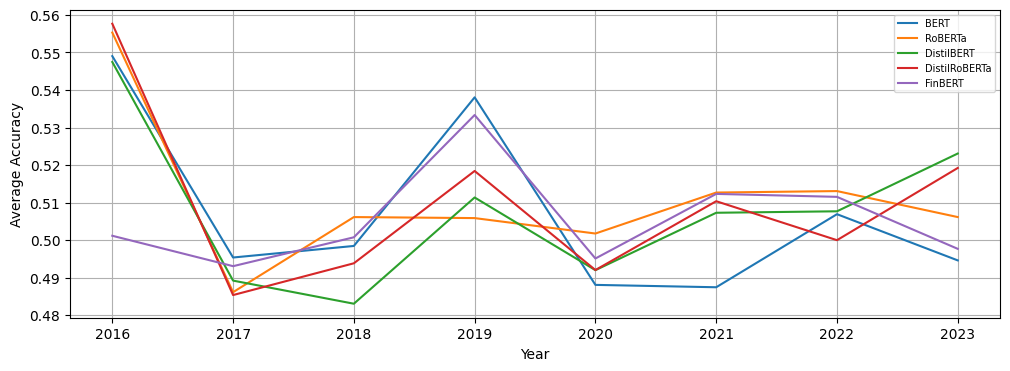

In [ ]:
get_report_acc_all()

In [ ]:
def plot_accuracy_by_ticker():

    all_acc = pd.concat([bert_acc, roberta_acc, dBert_acc, dRoberta_acc, finbert_acc], ignore_index=True)
    all_acc = all_acc.merge(df_to_sort, on='PERMCO', how='inner').sort_values(by=['market_cap'], ascending=False)

    # Define the number of columns for subplots
    num_columns = 4
    unique_permcos = all_acc['TICKER'].unique()
    num_permcos = len(unique_permcos)

    # Calculate number of rows needed based on the number of PERMCOs and desired columns
    num_rows = (num_permcos + num_columns - 1) // num_columns  # Ensures enough rows are included

    # Create a figure with subplots arranged into the desired number of rows and columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 2 * num_rows), sharex=False)

    # Flatten the axes array for easier iteration if it's multidimensional
    axes = axes.flatten()

    # Plot each PERMCO's data on a separate subplot
    for idx, permco in enumerate(unique_permcos[:]):
        permco_data = all_acc[all_acc['TICKER'] == permco]

        permco_data['predict_year'] = permco_data['start_year'] + 11
        sorter=['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']
        tmp2 = permco_data.sort_values(by=['model'], key=lambda column: column.map(lambda e: sorter.index(e)))
        tmp2 = tmp2.groupby(['predict_year', 'model'])['accuracy'].mean().reset_index()

        axes[idx].plot(tmp2[tmp2['model']=='BERT']['predict_year'], tmp2[tmp2['model']=='BERT']['accuracy'], label='BERT')
        axes[idx].plot(tmp2[tmp2['model']=='RoBERTa']['predict_year'], tmp2[tmp2['model']=='RoBERTa']['accuracy'], label='RoBERTa')
        axes[idx].plot(tmp2[tmp2['model']=='DistilBERT']['predict_year'], tmp2[tmp2['model']=='DistilBERT']['accuracy'], label='DistilBERT')
        axes[idx].plot(tmp2[tmp2['model']=='DistilRoBERTa']['predict_year'], tmp2[tmp2['model']=='DistilRoBERTa']['accuracy'], label='DistilRoBERTa')
        axes[idx].plot(tmp2[tmp2['model']=='FinBERT']['predict_year'], tmp2[tmp2['model']=='FinBERT']['accuracy'], label='FinBERT')

        axes[idx].legend(title="", fontsize=8, loc='lower left', fancybox=True, ncol=5, bbox_to_anchor=(0, -0.1))
        axes[idx].grid()
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
        axes[idx].set_title(permco)


    # Hide unused axes if there are any
    for ax in axes[idx + 1:]:
        ax.set_visible(False)

    # Set common labels
    plt.xlabel('')
    plt.tight_layout()
    plt.grid(True)  # Show grid
    plt.title('Comparative Out-of-Sample Accuracy')
    plt.show()

<ipython-input-80-b912c9754df4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permco_data['predict_year'] = permco_data['start_year'] + 11
<ipython-input-80-b912c9754df4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permco_data['predict_year'] = permco_data['start_year'] + 11
<ipython-input-80-b912c9754df4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

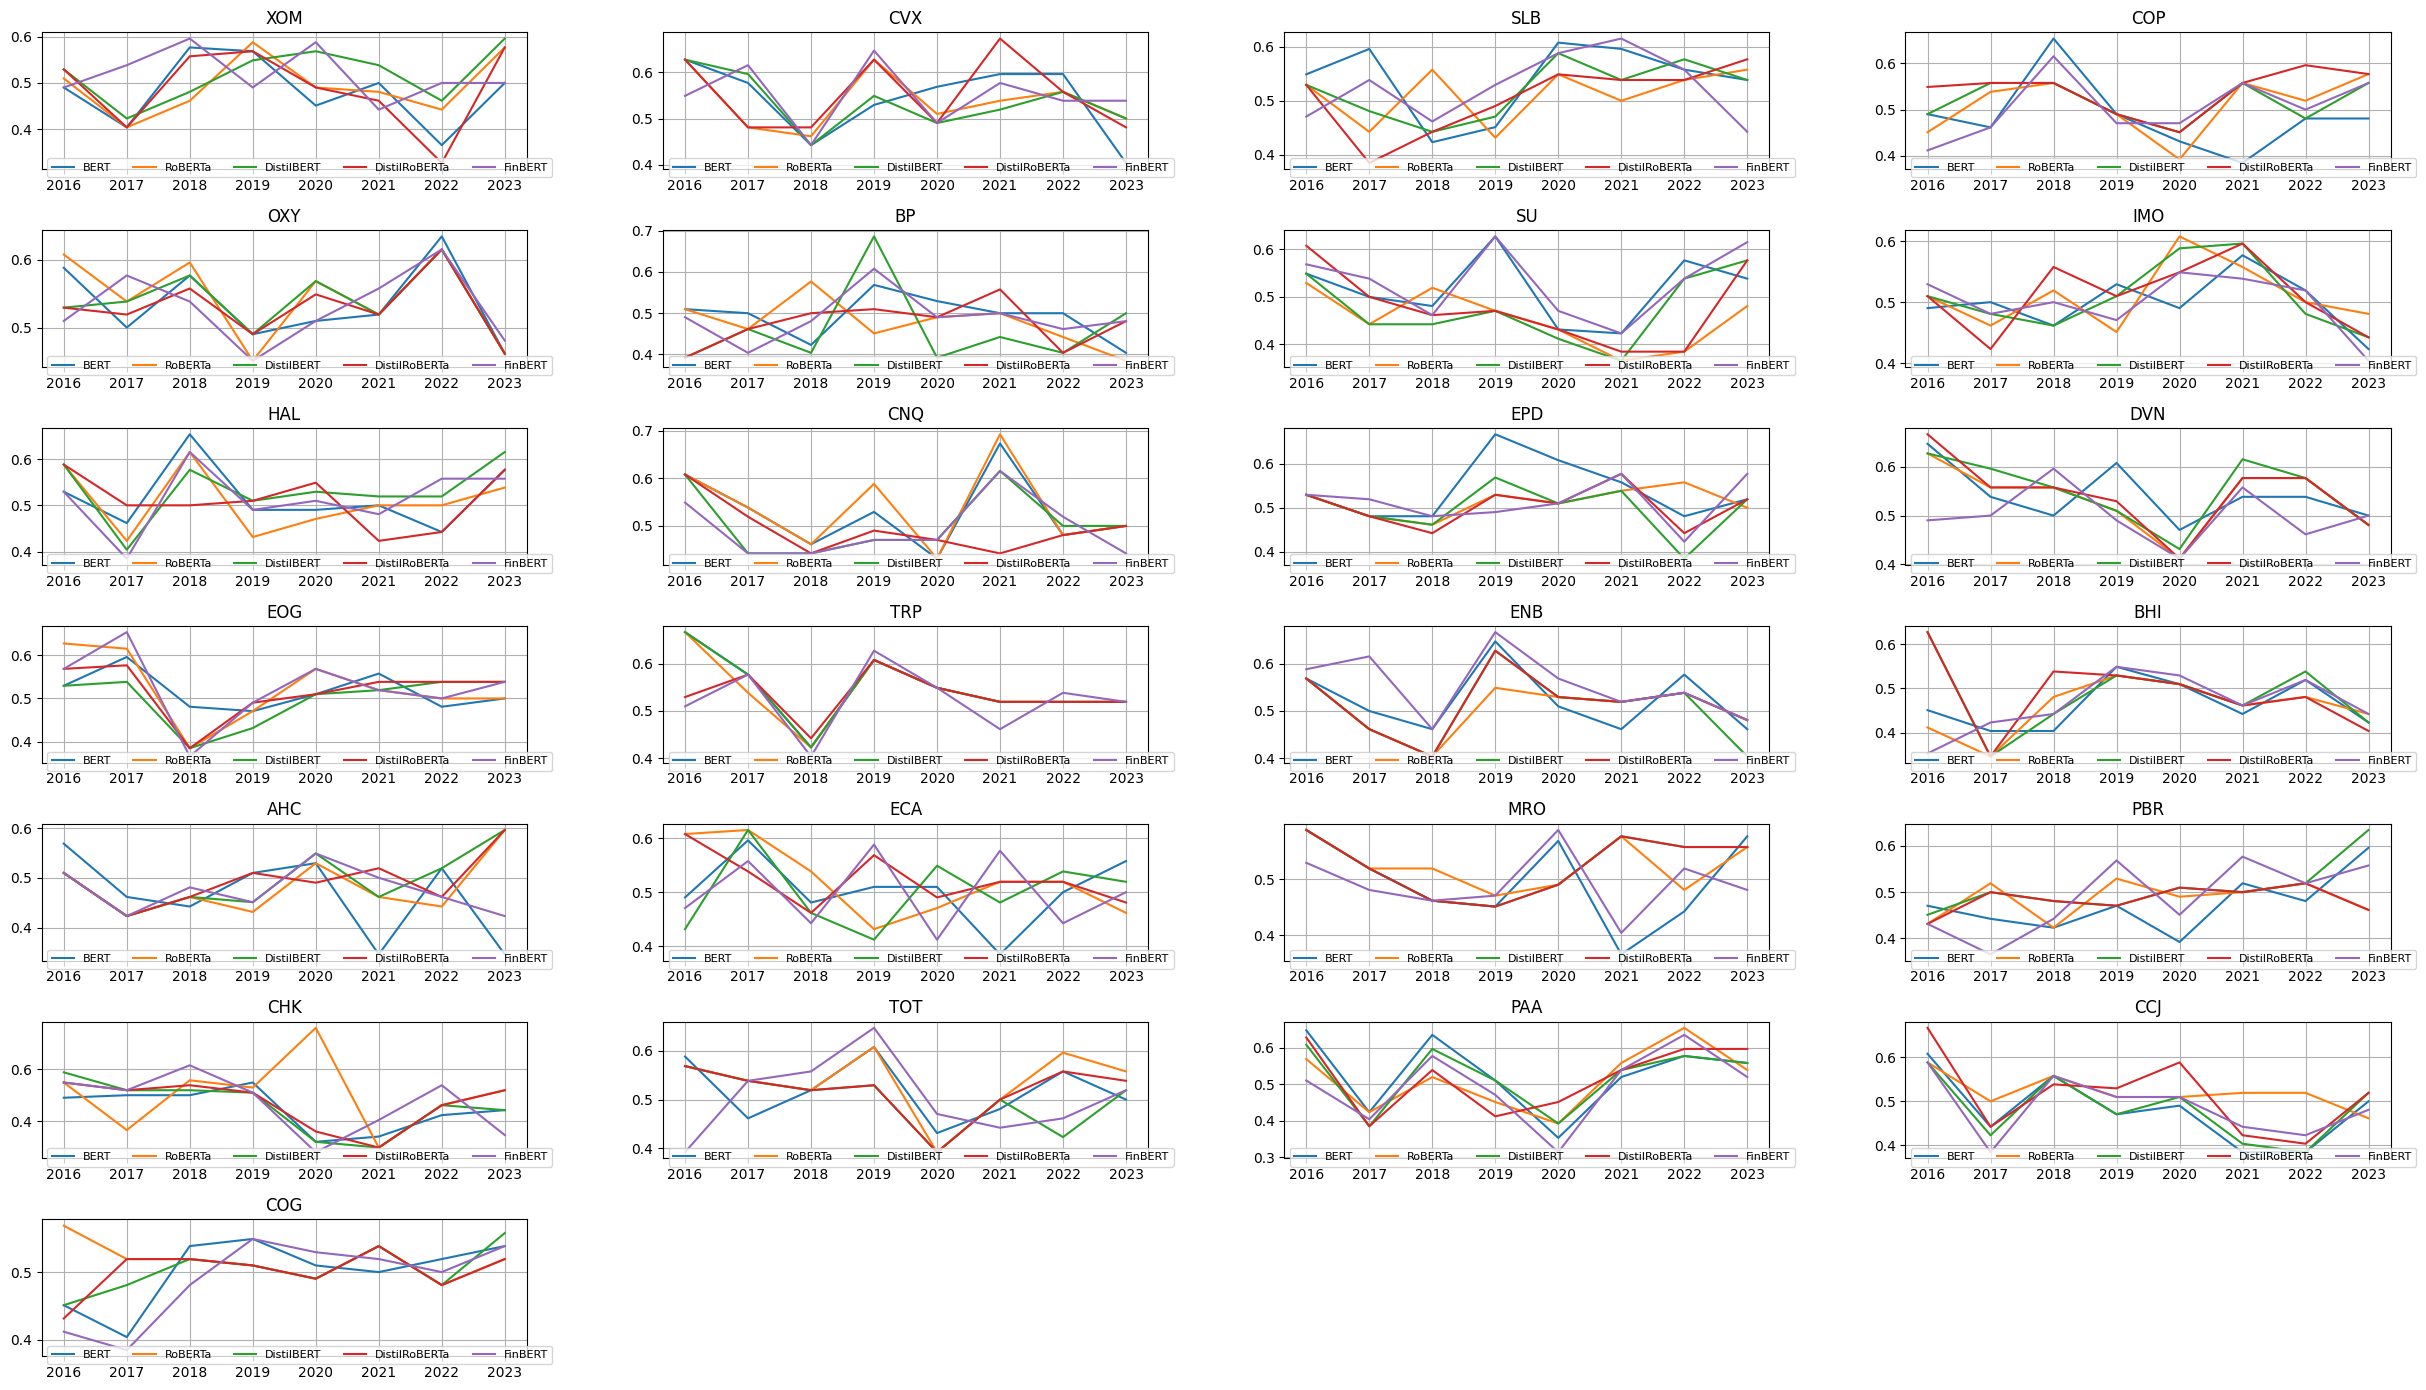

In [ ]:
plot_accuracy_by_ticker()